<a href="https://colab.research.google.com/github/Guillem96/efficientdet-tf/blob/master/examples/Train_EfficientDet_with_Labelme_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Efficientdet with Labelme Dataset

In this notebook, I provide an example on how you can easily finetune am¡n [EfficientDet](https://arxiv.org/abs/1911.09070) object detector using your dataset created with labelme, or a dataset formatted as labelme output.

This EfficientDet implementation tries to keep things simple. To get more information about the implementation, refer to my [GitHub Repository](https://github.com/Guillem96/efficientdet-tf).

Usually, papers with code shared on GitHub can only be trained using a CLI, this makes the things quite complex when you later want to use the resulting model in your application. Therefore, I go one step forward and I try to provide a convenient API to the final user to easily train and use a model.

## Install Code Dependencies

Since, Google Colab already provides a lot of Python Machine Learning packages including TensorFlow, we only have to install the `efficientdet` package and a simple CLI named `gdown` to download the Pokemon dataset from Google Drive.

**Since we are downgrading numpy, after running this cell, we have to restart the kernel**

In [1]:
!pip install git+https://github.com/Guillem96/efficientdet-tf
!pip install gdown
!pip install numpy==1.17.0 # PyCOCOAPI bug
!pip install tensorflow-addons==0.10.0

  Cloning https://github.com/Guillem96/efficientdet-tf to /tmp/pip-req-build-fp9wzt4r
  Running command git clone -q https://github.com/Guillem96/efficientdet-tf /tmp/pip-req-build-fp9wzt4r
  Created wheel for efficientdet: filename=efficientdet-0.1-cp36-none-any.whl size=52882 sha256=e43b4314258b9381656fab07913cf3e54c111a6755a3719a29420f825e4cce9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2rd9kojx/wheels/db/87/76/192b8b645e1cb455fa7f38d3790779111aee7fd0635270bffc
Successfully built efficientdet


In [2]:
!nvidia-smi

Wed May 27 05:26:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Download the pokemon dataset

The Pokemon dataset is an object detection dataset created an labeled by me. The daset comes with images containing 5 different pokemon figures:
- Treecko
- Mewtwoo
- Greninja
- Solgaleo
- Psyduck

The dataset is labeled using the [labelme](https://github.com/wkentaro/labelme) tool using rectangles.

In [0]:
%%capture
!gdown https://drive.google.com/uc?id=1uN1B-lfQSdT2ouY36XZZpZPzf3w9fpjR
!unzip pokemon-od.zip

In [0]:
#@markdown ## `import *`

import json
from pathlib import Path

from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

import efficientdet

First of all we have to choose which EfficientDet we want to train. This is needed because depending on the choosed model, we are going to use a different image size.

In [0]:
#@markdown EfficientDet compound scaling (Most times with D0 or D1 you'll be OK)

D = 0 #@param {type: "slider", min: 0, max: 7}

In [6]:
model_config = efficientdet.config.EfficientDetCompudScaling(D=D)
im_size = model_config.input_size

print('Working with images of shape (H, W):', im_size)

Working with images of shape (H, W): (512, 512)


## Basic Dataset Exploration

After we `unzip` the Pokemon dataset, at the top level, we can see a text file and a directory.

The text file is named `pokemon.names`. This file contains the 5 classes (the different Pokemon), that appear throughout the dataset. The Pokemon names are separated by a newline (`\n`). This file will come handy when generating the 
class to index mapping. 

In [10]:
data_path = Path('.')
class_names_file = data_path / 'pokemon.names'
!cat {str(class_names_file)}

treecko
mewtwo
greninja
psyduck
solgaleo

When working with `efficientdet` package, is a good practice to organize your class names this way. 

Using the method `read_class_names`, we generate the class to index mapping.

In [11]:
classes, class2idx = efficientdet.utils.io.read_class_names(class_names_file)
class2idx

{'greninja': 2, 'mewtwo': 1, 'psyduck': 3, 'solgaleo': 4, 'treecko': 0}

Later, I was talking about a directory that was in the pokemon dataset top level. This directory contains both, the images and their correspondign annotations. For each image named `image.jpg` we have a json annotation called `image.json`.

In [12]:
root_data = data_path / 'pokemon'
sample_images = list(root_data.glob('*.jpg'))[:3]
sample_annots = [root_data / f'{p.stem}.json' for p in sample_images]

for im_f, annot_f in zip(sample_images, sample_annots):
    print('Image:', str(im_f), '--> Annot:', str(annot_f))

Image: pokemon/IMG_20191228_190353.jpg --> Annot: pokemon/IMG_20191228_190353.json
Image: pokemon/IMG_20191226_171634.jpg --> Annot: pokemon/IMG_20191226_171634.json
Image: pokemon/IMG_20191228_190141.jpg --> Annot: pokemon/IMG_20191228_190141.json


All images are `jpg`, therefore, we can easily handle them using `Pillow`.

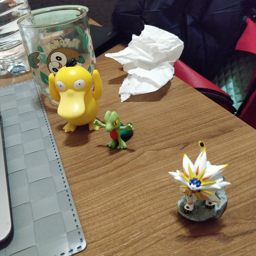

In [13]:
Image.open(sample_images[0]).resize((256, 256))

On the other hand, we can take a look to the annotations by just loading the json. The most important information of labelme annotations is inside the `shapes` properties, which contains the rectangles points and the corresponding class of the shape.

In [14]:
json.load(sample_annots[0].open())['shapes']

[{'fill_color': None,
  'flags': {},
  'label': 'psyduck',
  'line_color': None,
  'points': [[632.4285714285713, 814.1428571428571],
   [1375.2857142857142, 1842.7142857142856]],
  'shape_type': 'rectangle'},
 {'fill_color': None,
  'flags': {},
  'label': 'treecko',
  'line_color': None,
  'points': [[1260.9999999999995, 1499.8571428571427],
   [1832.428571428571, 2028.428571428571]],
  'shape_type': 'rectangle'},
 {'fill_color': None,
  'flags': {},
  'label': 'solgaleo',
  'line_color': None,
  'points': [[2268.142857142857, 1921.285714285714],
   [3132.4285714285706, 3006.9999999999995]],
  'shape_type': 'rectangle'}]

Using the `efficientdet.data.labelme` module, we can create a `tf.data.Dataset` with single function call.

In [15]:
ds = efficientdet.data.labelme.build_dataset(
    annotations_path=root_data, 
    images_path=root_data, 
    class2idx=class2idx,
    im_input_size=im_size,
    shuffle=True)

image, (labels, bbs) = next(iter(ds))

print('Image shape:', image.shape)
print('Labels shape:', labels.shape)
print('Bounding boxes shape:', bbs.shape)

Image shape: (512, 512, 3)
Labels shape: (1,)
Bounding boxes shape: (1, 4)


When working with `efficientdet` package, you have to be consistent when returing an instance using the TensorFlow datatsets pipelines. You always have to return an object of this type: `Tuple[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]`.

The first element of the outer tuple, is an `tf.Tensor` encoding an input image, while the second element of the tuple, is again a tuple, but this time containing first a `tf.Tensor` containing the labels, and finally a `tf.Tensor` containing the bounding boxes wrapping the instances. 

The types and shapes are:

| element | dtype | shape |
|--------|--------|-----------
| image | tf.float32 | [HEIGHT, WIDTH, 3] |
| labels | tf.int32 | [N_ELEMS] |
| boxes | tf.float32 | [N_ELEMS, 4] |

Boxes are always formated as (x_min, y_min, x_max, y_max) and using absolute image sizes.

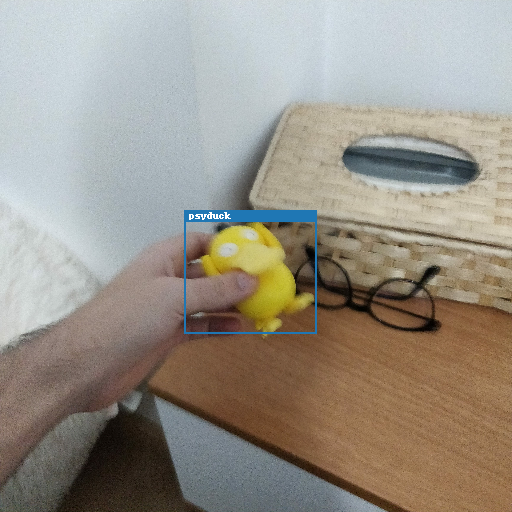

In [16]:
image, (labels, bbs) = next(iter(ds))

image_n = efficientdet.data.preprocess.unnormalize_image(image)

# Covert dataset labels to names
labels_name = [classes[l] for l in labels.numpy().tolist()]

# For each different name get a color
colors = efficientdet.visualizer.colors_per_labels(labels_name)

# Get a Pillow image with drew boxes, and automatically plot it
efficientdet.visualizer.draw_boxes(image_n, bbs, labels_name, colors=colors)

## Preparing data for training

Here we have three main steps to complete:

1. Split data into train and validation. 
2. Batch the data to enhance training.
3. Usually, when working with single stage detectors, instead of predicting the boxes, we predict a regression to fit the anchors to the ground truth boxes. Therefore, we have to convert the ground truth bounding boxes to relative anchors offsets.


### Generate train and validation datasets

Generating a train and validation dataset using `tf.data.Dataset` can be a little bit tricky because there is no native method and also because the datasets are lazy, therefore we do not know the dataset size.

Here, since we are working with a pretty small dataset, we can iterate over it to compute the length.

When working with larger datasets, it is a better practice to keep different file system folders contianing the train and validation instances.

In [0]:
ds_len = sum(1 for _ in ds)

train_len = int(ds_len * .9) # 90% of validation data

train_ds = ds.take(train_len) # Take the first instances
valid_ds = ds.skip(train_len) # Skip the first instances, so the sets do not intersect

# Data augmentation on training set
train_ds = (train_ds
            .map(efficientdet.augment.RandomHorizontalFlip())
            .map(efficientdet.augment.RandomCrop()))

### Batching the data

Probabily this step is harder than the second one, but it is not difficult. Note that when working with object detection, all images won't contain the same number of object, therefore we have to pad both the labels and boxes, so all images in a batch contain the same number of instances.

To generate a padded batch, we can use the method `padded_batch` from `tf.data.Dataset`. 

In [0]:
batch_size = 12 #@param {type: "slider", min: 2, max: 64}

In [0]:
padded_image_shape = (*im_size, 3)
padded_labels_shape = (None,)
boxes_padded_shape = (None, 4)

train_ds = train_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape, 
                                                (padded_labels_shape, 
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

valid_ds = valid_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape, 
                                                (padded_labels_shape, 
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

Wrapping dataset for training

In [0]:
wrapped_train_ds = efficientdet.wrap_detection_dataset(
        train_ds, im_size=im_size, num_classes=len(class2idx))

wrapped_valid_ds = efficientdet.wrap_detection_dataset(
        valid_ds, im_size=im_size, num_classes=len(class2idx))

## Training

In [0]:
epochs = 20 #@param {type: "slider", min: 2, max: 120}

#@markdown Compute COCO mAP every `valdiate_freq` epochs
valdiate_freq = 10 #@param {type: "slider", min: 1, max: 10}


We first create the model. In this example, we are going to instantiate an EfficientDet that with pretrained weights on VOC2007 dataset.

To create the model we have to specify 5 parameters:

- `D`: The EfficientDet compound scaling.
- `num_classes`: The number of classes available in our dataset. It can be simply computed as the length of the class to index mapping. `len(class2idx)`.
- `training_mode`: The training of a single stage detector is quite different from the inference step, therefore, we need a mechanism to handle this variation. When training we set it to `True`.
- `weights`: Similar to `keras.applications` API, we specify the pretrained weights by name. In this case, we select `D0-VOC`.
- `custom_training_head`: Since we are finetuning a model, we want to change the classification head. Therefore, we set this parameter to `True`.

In [22]:
model = efficientdet.EfficientDet(D=D,
                                  num_classes=len(class2idx),
                                  training_mode=True,
                                  weights='D0-VOC',
                                  custom_head_classifier=True)

Now we create the optimizer. 

Since the weight decay regularization is pretty important for this use case, and neither TensorFlow nor Keras provide a flexible way to implement it, I prefered to use TensorFlow addons, which provides optimizers with weight decay.

Also the optimizer scheduler is really important. If you don't use it the training will take too long, and probabily the model won't converge.

In [0]:
# We have to calculate the steps per epoch in order to create the 
# learning rate scheduler
steps_per_epoch = sum(1 for _ in wrapped_train_ds)
lr = efficientdet.optim.WarmupCosineDecayLRScheduler(
            1e-4,
            warmup_steps=steps_per_epoch,
            decay_steps=steps_per_epoch * (epochs - 1),
            alpha=0.1)
 
optimizer = tfa.optimizers.AdamW(learning_rate=lr, 
                                 weight_decay=4e-5)

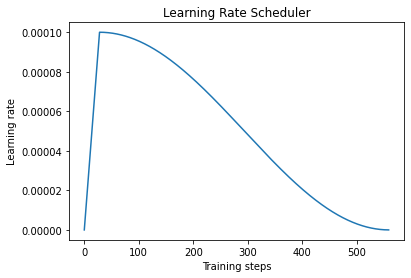

In [24]:
lrs = [lr(o) for o in range(steps_per_epoch * epochs)]

plt.plot(range(len(lrs)), lrs)
plt.xlabel('Training steps')
plt.ylabel('Learning rate')
plt.title('Learning Rate Scheduler')
plt.show();

Finally, we create the losses and compile the model.

In [26]:
clf_loss = efficientdet.losses.EfficientDetFocalLoss()
reg_loss = efficientdet.losses.EfficientDetHuberLoss()

model.compile(loss=[reg_loss, clf_loss], 
              optimizer=optimizer, loss_weights=[1., 1.])

model.build([None, *im_size, 3])
model.summary()

Model: "efficient_det"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EfficientNetB0 (Model)       [(None, None, None, 96),  4049564   
_________________________________________________________________
bi_fpn (BiFPN)               multiple                  1155705   
_________________________________________________________________
retina_net_bb_predictor (Ret multiple                  17892     
_________________________________________________________________
retina_net_classifier_1 (Ret multiple                  18477     
Total params: 5,241,638
Trainable params: 5,192,070
Non-trainable params: 49,568
_________________________________________________________________


In [27]:
callbacks = [
    efficientdet.callbacks.COCOmAPCallback(valid_ds, 
                                           class2idx, 
                                           validate_every=valdiate_freq)
]

model.fit(wrapped_train_ds, 
          validation_data=wrapped_valid_ds, 
          epochs=epochs,
          callbacks=callbacks)

creating index...
index created!
Epoch 1/20
28/28 [==============================] - 99s 4s/step - loss: 1.2901 - output_1_loss: 0.1213 - output_2_loss: 1.1689 - val_loss: 1.2334 - val_output_1_loss: 0.0690 - val_output_2_loss: 1.1644
Epoch 2/20
28/28 [==============================] - 92s 3s/step - loss: 1.2102 - output_1_loss: 0.0593 - output_2_loss: 1.1510 - val_loss: 1.2122 - val_output_1_loss: 0.0491 - val_output_2_loss: 1.1630
Epoch 3/20
28/28 [==============================] - 92s 3s/step - loss: 1.1406 - output_1_loss: 0.0427 - output_2_loss: 1.0978 - val_loss: 1.2031 - val_output_1_loss: 0.0456 - val_output_2_loss: 1.1575
Epoch 4/20
28/28 [==============================] - 92s 3s/step - loss: 1.0627 - output_1_loss: 0.0362 - output_2_loss: 1.0265 - val_loss: 1.1363 - val_output_1_loss: 0.0428 - val_output_2_loss: 1.0935
Epoch 5/20
28/28 [==============================] - 92s 3s/step - loss: 0.9899 - output_1_loss: 0.0313 - output_2_loss: 0.9586 - val_loss: 0.9419 - val_output_

## Making predictions

As we mentioned earlier, the training step and the inference step are pretty different. Therefore, before start making predictions we have to change the behaviour of our model by setting the `training_mode` to `False` and incrementing the `score_threshold` so we obtain high quality predictions. 

In [0]:
model.training_mode = False
model.filter_detections.score_threshold = 0.8

In [0]:
image, _ = next(iter(valid_ds.unbatch().shuffle(20).take(1)))

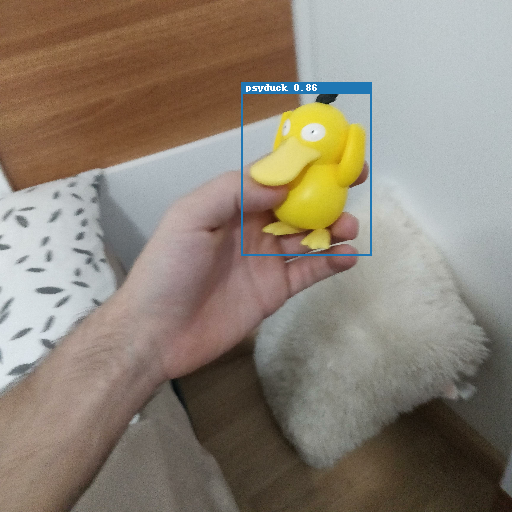

In [57]:
bbs, labels, scores = model(tf.expand_dims(image, 0), training=False)

image_n = efficientdet.data.preprocess.unnormalize_image(image)

# Covert dataset labels to names
labels_name = [classes[l] for l in labels[0].numpy().tolist()]

# For each different name get a color
colors = efficientdet.visualizer.colors_per_labels(labels_name)

# Get a Pillow image with drew boxes, and automatically plot it
efficientdet.visualizer.draw_boxes(
    image_n, bbs[0], labels_name, scores=scores[0], colors=colors)